# Fitting SVG signal

In this notebook I will take a random sample of points from the SVG smoothed signal (created in Sunspot Data Plotting) and see if the Gaussian process can (essentially) fill in the rest of the points.

For this I will be using the ***qusi-periodic kernel function***, given by:

$$ k_{i,j} = A^2 \exp{\left[-\frac{(x_i-x_j)^2}{2 l^2} - \sin^2{\left(\frac{\pi (x_i - x_j)}{P} \right)} \right]} + \sigma^2 \delta_{ij}$$

A list of kernel functions for PyMC3 can be found at https://docs.pymc.io/en/v3/api/gp/cov.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy as sp
import arviz as az

In [2]:
df = pd.read_csv('Data/SVG_poly1.csv') # importing data for SVG polyorder = 1
X = ((df.Year).values).reshape(-1,1)
y = (df.Sunspot_Number).values
yerr = np.zeros(len(X)) 

In [3]:
rng = np.random.RandomState(1) # random selection of points
training_indices = rng.choice(np.arange(y.size), size=100, replace=False)

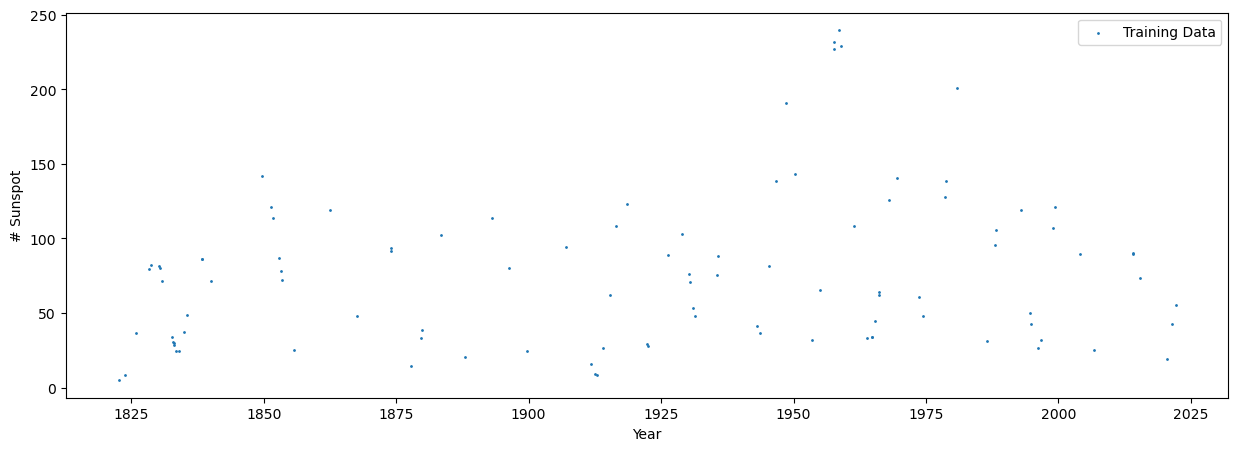

In [4]:
X_train = X[training_indices] # x & y values of random indicies
y_train = y[training_indices]

fig, ax = plt.subplots(1, dpi=100, figsize=[15,5])

ax.scatter(X_train, y_train, label='Training Data', s=1)
ax.set_xlabel('Year')
ax.set_ylabel("# Sunspot")
ax.legend();

Here we are taking a sample of points from our data (which contains over 70,000 datapoints). The training data represents most of the shape of the distribution, so we will observe how well it can be modelled using a Gaussian process.

PyMC3 doesn't contain the quasi-periodic kernel, but it *does* contain a **periodic kernel** as well as a **squared exponential kernel**, which we can multiply togehter to arrive at our desired kernel.

In [140]:
with pm.Model() as model:
    
    period = pm.Normal('Period', 11, 1)
    A = pm.Gamma('A', 2, 2)
    length_scale1 = pm.Deterministic('Length Scale 1', 
                                    pm.Beta('ls1', 2, 2) * 100) # seems to focus around 2 
                                                    # so no need for a large distribution
    length_scale2 = pm.Deterministic('Length Scale 2', 
                                    pm.Gamma('ls2', 2, 2))
    
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1) # periodic kernel
    cov_SE = pm.gp.cov.ExpQuad(1, ls=length_scale2) # squared exponential kernel
    cov_qp = A**2 * cov_SE * cov_periodic # quasi-periodic kernel
    
    mu = pm.Normal('mu', 100, 50) # note: using LogNormal makes no difference
    const_func = pm.gp.mean.Constant(mu)
    
    gp = pm.gp.Marginal(cov_func=cov_qp, mean_func=const_func)  # implementation of the sum of a GP prior and noise

    y_ = np.exp(np.log(gp.marginal_likelihood("y", X=X_train, y=y_train, noise=1)))

    tr = pm.sample(return_inferencedata=True) # finds local maximimum 'a posteriori point' given a model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, ls1, A, Period]


ValueError: Not enough samples to build a trace.

The above code required a lot of trial and error to see at which points the priors converge to their optimal values, and continued readjustment of priors eventually lead to the values we have below.

In [200]:
## Seeing what happens when we change either of our length scales,
## with the other parameters remaining the same

with pm.Model() as model:
    
    period = pm.Normal('Period', 11, 1)
    A = pm.Gamma('A', 2, 2)
    length_scale1 = pm.Deterministic('Length Scale 1', 
                                    pm.Beta('ls1', 2, 2)* 100)
    length_scale2 = pm.Deterministic('Length Scale 2', 
                                    pm.Beta('ls2', 2, 2)* 10 + 7)
    
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1) # periodic kernel
    cov_SE = pm.gp.cov.ExpQuad(1, ls=length_scale2) # squared exponential kernel
    cov_qp = A**2 * cov_SE * cov_periodic # quasi-periodic kernel
    
    mu = pm.Normal('mu', 100, 50) # note: using LogNormal makes no difference
    const_func = pm.gp.mean.Constant(mu)
    
    gp = pm.gp.Marginal(cov_func=cov_qp, mean_func=const_func)  # implementation of the sum of a GP prior and noise

    y_ = np.exp(np.log(gp.marginal_likelihood("y", X=X_train, y=y_train, noise=1)))

    tr = pm.sample(return_inferencedata=True) # finds local maximimum 'a posteriori point' given a model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, ls2, ls1, A, Period]


/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 226 seconds.


array([[<AxesSubplot:title={'center':'Period'}>,
        <AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'ls1'}>,
        <AxesSubplot:title={'center':'Length Scale 1'}>,
        <AxesSubplot:title={'center':'ls2'}>],
       [<AxesSubplot:title={'center':'Length Scale 2'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

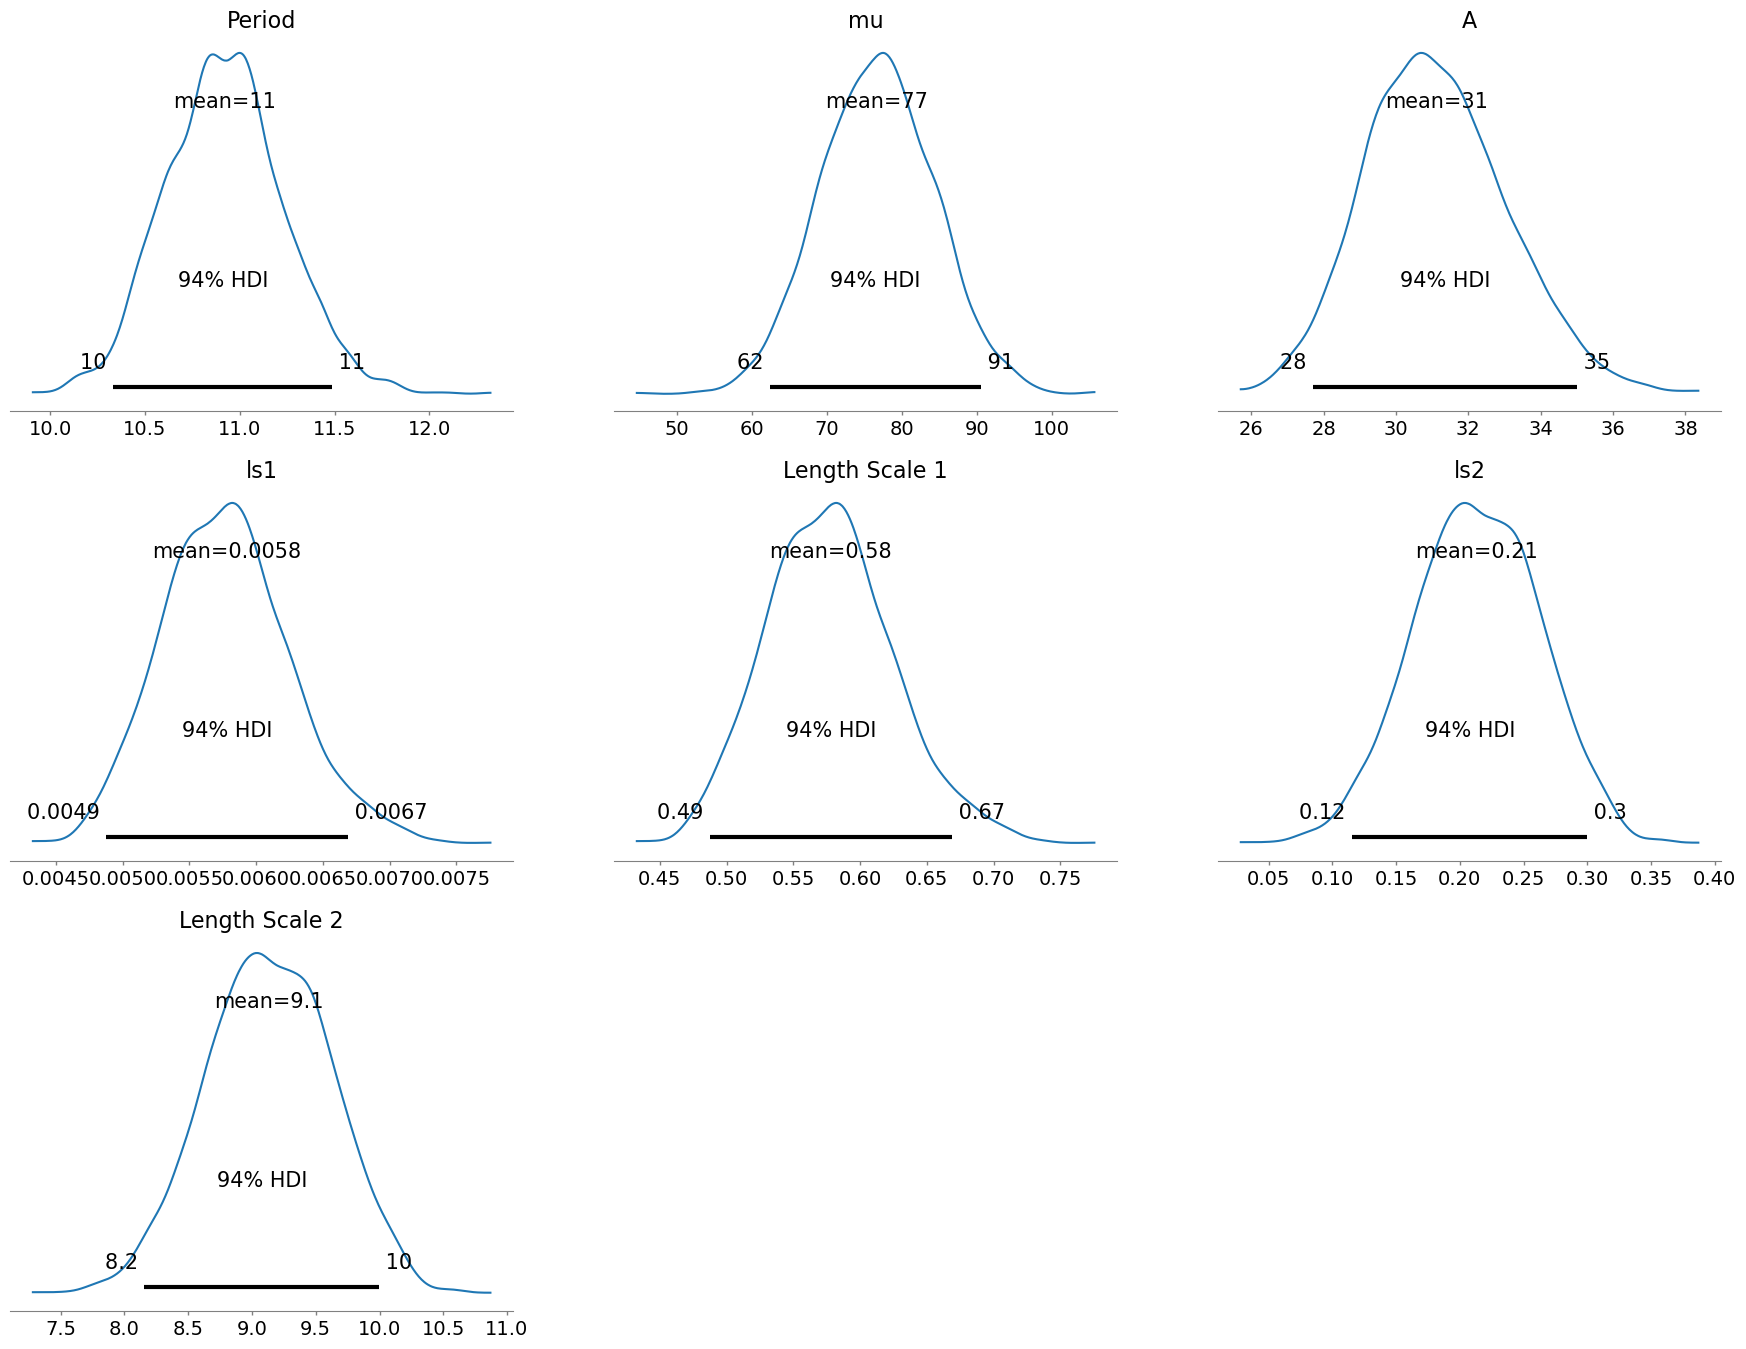

In [201]:
az.plot_posterior(tr)

In [202]:
X_new = np.linspace(1800, 2055, 500)[:, None]
with model:
    fnew = gp.conditional("f_new", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=100, var_names=["f_new"])#

/opt/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


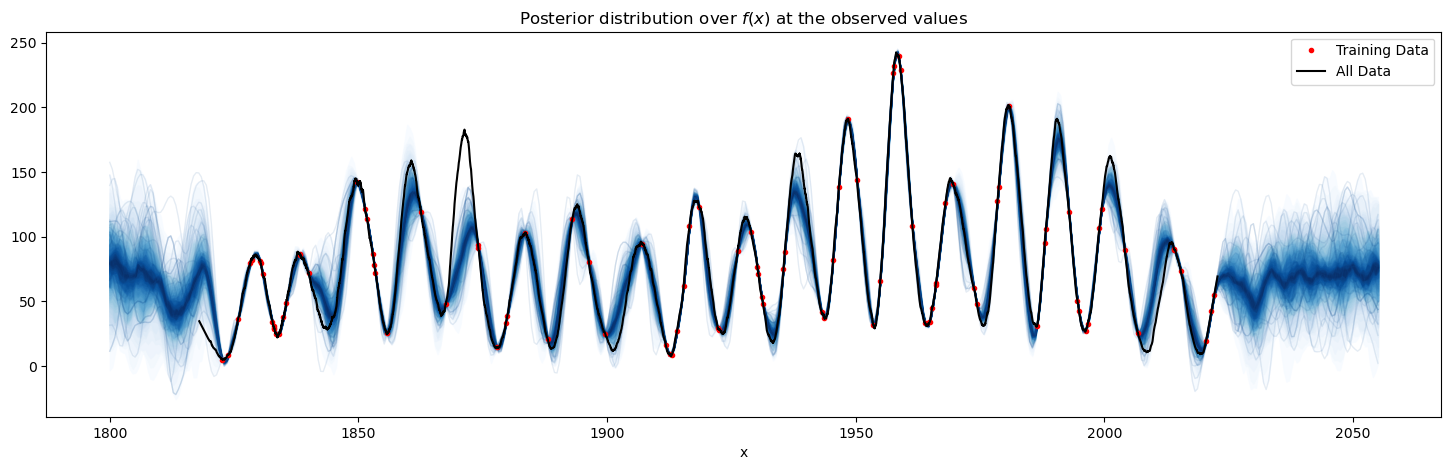

In [204]:
from pymc3.gp.util import plot_gp_dist

# draw plot
fig = plt.figure(figsize=(18, 5))
ax = fig.gca()
plot_gp_dist(ax, ppc['f_new'], X_new, palette="Blues")

# plot original data and true function
plt.plot(X_train, y_train, "or", ms=3, alpha=1.0, label="Training Data")
plt.plot(X, y, color="black", label="All Data")

plt.xlabel("x")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

#### Comment on plot:

Here we have used a ***periodic kernel*** as opposed to the ***quasi-periodic kernel*** we want. We see that there are no uncertainty regions, which is a problem, and given the amoutn of data present the period doesn't seem to be a good enough fit. 